In [1]:
import glob
import json
import pathlib
import typing

import pandas as pd
import seaborn as sns

import config

In [2]:
QUESTIONNAIRE: str = "moral-foundations"

CFG = config.Config(
    data_dir=pathlib.Path("../data/"),
    report_dir=pathlib.Path(f"../report/"),
)

In [3]:
table_styles = [
    {
        'selector': 'th', 'props': 'padding: 0.25rem;',
    },
    {
        'selector': '.index_name, .col_heading, .row_heading',
        'props': 'text-align: left; background: #EEE'
    },
    {
        'selector': 'tbody td', 'props': 'text-align: right;',
    },
]

In [3]:
responses: pd.DataFrame = (
    pd.concat([
        pd.json_normalize(json.load(open(file, 'r')))
        for file in glob.glob(f'{CFG.report_dir}/{QUESTIONNAIRE}/**/*.json', recursive=True)
    ])
    .pipe(lambda _df: _df.assign(
        category=_df["category"].astype("category"),
        model=_df["model"].astype("category").str.split("-").str[0],

        response=pd.to_numeric(_df["response"]),
        number=pd.to_numeric(_df["number"])
    ))
    .set_index(["category", "number", "model", "persona"])
    .sort_index()
    .dropna()
)
responses.to_parquet(f"{CFG.report_dir}/{QUESTIONNAIRE}/agg.responses.parquet")
responses

response
category  number model    persona           
agreement 0      gemma:7b base           5.0
                          base           5.0
                          base           5.0
                          base           5.0
                          base           5.0
...                                      ...
relevance 15     qwen:72b moderate       5.0
                          moderate       5.0
                          moderate       0.0
                          moderate       0.0
                          moderate       5.0

[44415 rows x 1 columns]

In [5]:
(
    responses.reset_index()
    [["model", "persona"]]
    .value_counts()
    .to_frame()
    .sort_index()
)

count
model         persona            
gemma:7b      base           1588
              conservative   1558
              liberal        1533
              moderate       1545
llama2:70b    base           1600
              conservative   1539
              liberal        1600
              moderate       1600
llama3:70b    base           1600
              conservative   1600
              liberal        1600
              moderate       1600
mistral:7b    base           1594
              conservative   1582
              liberal        1579
              moderate       1561
mixtral:8x22b base           1598
              conservative   1600
              liberal        1600
              moderate       1600
mixtral:8x7b  base           1590
              conservative   1592
              liberal        1581
              moderate       1600
qwen:72b      base           1600
              conservative   1594
              liberal        1595
              moderate       1586

In [4]:
responses_w_dimension = responses.join(pd.DataFrame.from_records([
    {"category": val[0],
    "number": val[1],
    "dimension": key
    } for key, value in CFG.questionnaires[QUESTIONNAIRE].mapping.items() for val in value
], index=["category", "number"])).set_index("dimension", append=True)
responses_w_dimension

response
category  number model    persona  dimension          
agreement 0      gemma:7b base     harm            5.0
                                   harm            5.0
                                   harm            5.0
                                   harm            5.0
                                   harm            5.0
...                                                ...
relevance 15     qwen:72b moderate purity          5.0
                                   purity          5.0
                                   purity          0.0
                                   purity          0.0
                                   purity          5.0

[44415 rows x 1 columns]

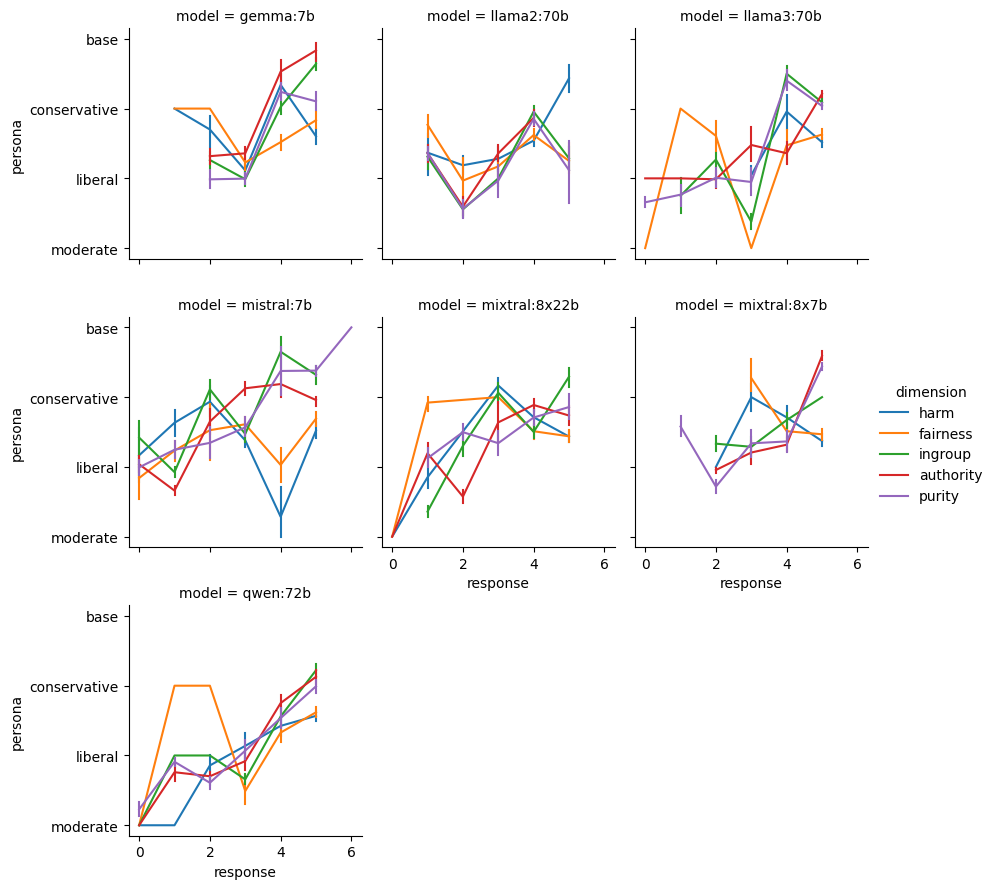

In [18]:
grid = sns.FacetGrid(data=responses_w_dimension.reset_index(), hue="dimension", col="model", col_wrap=3)
grid.map_dataframe(sns.lineplot, y="persona", x="response", err_style="bars")

grid.add_legend()


In [20]:
dimension_agg = (
    responses_w_dimension
    .groupby(["model", "persona", "dimension"], observed=True) # "model", 
    ["response"]
    .agg(
        mean="mean",
        var="var"
    )
    .sort_index()
    .reset_index(["model", "persona"]) # "model", 
    .pivot(columns=["model", "persona"]) # "model"
    .T
)
dimension_agg

dimension                        authority  fairness      harm   ingroup  \
     model         persona                                                 
mean gemma:7b      base           3.373737  4.279461  4.334448  3.801347   
                   conservative   2.750000  3.364865  3.483221  3.323024   
                   liberal        2.709790  4.200692  4.130137  2.955017   
                   moderate       2.670175  3.585366  3.679054  2.714789   
     llama2:70b    base           3.126667  3.806667  3.923333  3.806667   
                   conservative   3.167910  3.078767  3.433898  3.782007   
                   liberal        2.086667  3.843333  3.370000  3.170000   
                   moderate       2.810000  3.400000  3.410000  3.160000   
     llama3:70b    base           3.650000  4.826667  4.700000  3.556667   
                   conservative   4.926667  4.390000  4.390000  4.886667   
                   liberal        1.796667  5.000000  5.000000  2.380000   
                   moderate       2.950000  4.086667  4.286667  2.826667   
     mistral:7b    base           2.866221  4.100000  3.556667  3.180000   
                   conservative   2.861953  2.511864  3.210702  2.376712   
                   liberal        1.090301  3.806667  3.725753  1.667808   
                   moderate       1.674912  3.027027  3.489933  1.928814   
     mixtral:8x22b base           3.680000  4.510000  4.335570  3.446667   
                   conservative   4.356667  3.723333  4.203333  4.146667   
                   liberal        2.366667  4.726667  4.176667  2.600000   
                   moderate       2.993333  4.400000  3.963333  2.753333   
     mixtral:8x7b  base           4.143813  4.523810  4.148148  3.340000   
                   conservative   4.330000  4.496622  4.606667  3.813333   
                   liberal        2.790210  4.952862  4.493333  2.825503   
                   moderate       3.476667  4.433333  4.500000  3.166667   
     qwen:72b      base           4.483333  4.893333  4.830000  4.656667   
                   conservative   4.496667  4.486486  4.566667  4.530201   
                   liberal        2.490000  4.864865  4.591973  3.220000   
                   moderate       3.203333  4.323333  4.550000  3.498258   
var  gemma:7b      base           0.964578  0.533124  0.558910  1.058377   
                   conservative   0.325601  0.612185  1.476149  1.102192   
                   liberal        0.347062  0.772083  0.869604  0.640331   
                   moderate       0.257030  0.376428  0.937322  0.296459   
     llama2:70b    base           1.294939  0.216678  0.545942  0.156477   
                   conservative   1.188929  1.330544  0.845105  0.497453   
                   liberal        1.062698  0.252965  0.996421  1.004448   
                   moderate       1.184515  0.508361  0.657425  0.482676   
     llama3:70b    base           1.171405  0.143768  0.210702  1.030223   
                   conservative   0.068183  1.502910  0.847391  0.100825   
                   liberal        1.533768  0.000000  0.000000  0.804950   
                   moderate       0.763378  1.183099  0.760357  0.197280   
     mistral:7b    base           0.136405  0.892977  2.475039  1.311973   
                   conservative   1.605879  2.434383  2.307805  2.579250   
                   liberal        0.659604  1.648116  1.850710  1.047345   
                   moderate       0.893943  2.643335  2.324814  1.250017   
     mixtral:8x22b base           1.736722  0.250736  0.567148  0.977079   
                   conservative   0.230223  1.772698  1.105674  0.219220   
                   liberal        1.630992  0.199287  2.152631  1.103679   
                   moderate       2.200624  0.454849  2.022062  1.892129   
     mixtral:8x7b  base           0.801396  0.270762  0.809059  0.559599   
                   conservative   0.228528  0.305073  0.406644  1.155674   
                   liberal        0.797939  0.04

In [25]:
(
    dimension_agg
    .filter(like="var", axis=0)
    .droplevel(axis=0, level=None)
    .groupby("persona")
    .mean()
    .T
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .T
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .T
    .to_latex(
        buf=open(CFG.report_dir / QUESTIONNAIRE / f"tab.questionnaire.var.persona.dimension.tex", "w"),
        label=f"tab:questionnaire:{QUESTIONNAIRE}.var.persona.dimension",
        escape=True,
        float_format="{:0.3f}".format
    )
    
)

In [8]:
responses_agg: pd.DataFrame = (
    responses
    .groupby(["category", "number", "model", "persona"], observed=True)
    ["response"]
    .agg(
        mean="mean",
        var="var"
    )
    .sort_index()
    .reset_index(["model", "persona"])
    .pivot(columns=["model", "persona"])
)
responses_agg

mean                                              \
model             gemma:7b                                  llama2:70b   
persona               base conservative   liberal  moderate       base   
category  number                                                         
agreement 0       5.000000     1.680000  4.960000  3.000000       4.02   
          1       5.000000     3.240000  5.000000  4.380000       4.00   
          2       5.000000     4.900000  3.440000  3.000000       4.00   
          3       4.960000     3.340000  3.320000  3.080000       4.00   
          4       4.880000     5.000000  5.000000  4.220000       3.40   
          5       5.000000     5.000000  5.000000  5.000000       5.00   
          6       5.000000     5.000000  5.000000  5.000000       4.14   
          7       5.000000     2.740000  4.920000  3.160000       4.00   
          8       4.660000     2.380000  2.000000  2.140000       4.00   
          9       2.000000     2.000000  2.000000  2.000000       1.18   
          10      3.600000     2.140000  2.000000  2.140000       1.78   
          11      5.000000     5.000000  5.000000  5.000000       4.86   
          12      4.560000     4.260000  5.000000  3.980000       3.82   
          13      2.040000     2.080000  2.040000  2.040000       3.68   
          14      3.340000     2.280000  2.000000  2.040000       3.28   
          15      5.000000     3.940000  3.420000  3.080000       4.00   
relevance 0       3.000000     3.000000  3.000000  3.000000       2.82   
          1       3.020000     3.000000  3.023810  3.000000       3.12   
          2       4.020408     3.938776  3.625000  3.155556       3.76   
          3       3.560000     2.979167  3.000000  3.000000       3.66   
          4       4.020000     3.000000  2.977273  3.000000       3.86   
          5       2.918367     1.000000  1.000000  0.979592       1.12   
          6       3.980000     3.208333  3.666667  3.020408       3.84   
          7       4.063830     2.979167  3.040816  3.000000       3.94   
          8       4.020000     3.612245  3.733333  3.062500       3.90   
          9       3.000000     2.980000  3.000000  3.000000       3.20   
          10      4.000000     3.065217  3.063830  3.000000       3.44   
          11      4.000000     3.000000  3.000000  3.000000       3.86   
          12      4.020000     3.959184  4.000000  3.976744       3.96   
          13      3.041667     3.000000  3.000000  3.000000       3.50   
          14      3.360000     2.954545  3.023256  3.000000       3.44   
          15      4.000000     2.977778  2.955556  3.000000       4.00   

                                                                        ...  \
model                                          llama3:70b               ...   
persona          conservative liberal moderate       base conservative  ...   
category  number                                                        ...   
agreement 0          3.780000    4.22     4.00       5.00         3.00  ...   
          1          3.775510    4.00     4.00       5.00         4.72  ...   
          2          4.145833    3.42     3.34       4.88         5.00  ...   
          3          4.000000    2.08     3.80       4.86         5.00  ...   
          4          3.400000    2.30     4.00       4.06         5.00  ...   
          5          4.081633    4.64     4.50       5.00         5.00  ...   
          6          3.877551    4.02     4.00       5.00         5.00  ...   
          7          3.530612    4.12     4.00       5.00         5.00  ...   
          8          4.000000    2.94     3.30       2.78         5.00  ...   
          9          1.000000    1.00     1.12       2.00         5.00  ...   
          10         1.720000    1.00     2.40       2.26         5.00  ...   
          11         4.163265    2.18     4.00       5.00         5.00  ...   
          12         1.125000    3.88     3.14       5.00         1.74  ...   
          13  

In [7]:
responses_mean = (
    responses_agg
    .filter(like="mean")
    .droplevel(axis=1, level=None)
)
responses_mean

model             gemma:7b                                  llama2:70b  \
persona               base conservative   liberal  moderate       base   
category  number                                                         
agreement 0       5.000000     1.680000  4.960000  3.000000       4.02   
          1       5.000000     3.240000  5.000000  4.380000       4.00   
          2       5.000000     4.900000  3.440000  3.000000       4.00   
          3       4.960000     3.340000  3.320000  3.080000       4.00   
          4       4.880000     5.000000  5.000000  4.220000       3.40   
          5       5.000000     5.000000  5.000000  5.000000       5.00   
          6       5.000000     5.000000  5.000000  5.000000       4.14   
          7       5.000000     2.740000  4.920000  3.160000       4.00   
          8       4.660000     2.380000  2.000000  2.140000       4.00   
          9       2.000000     2.000000  2.000000  2.000000       1.18   
          10      3.600000     2.140000  2.000000  2.140000       1.78   
          11      5.000000     5.000000  5.000000  5.000000       4.86   
          12      4.560000     4.260000  5.000000  3.980000       3.82   
          13      2.040000     2.080000  2.040000  2.040000       3.68   
          14      3.340000     2.280000  2.000000  2.040000       3.28   
          15      5.000000     3.940000  3.420000  3.080000       4.00   
relevance 0       3.000000     3.000000  3.000000  3.000000       2.82   
          1       3.020000     3.000000  3.023810  3.000000       3.12   
          2       4.020408     3.938776  3.625000  3.155556       3.76   
          3       3.560000     2.979167  3.000000  3.000000       3.66   
          4       4.020000     3.000000  2.977273  3.000000       3.86   
          5       2.918367     1.000000  1.000000  0.979592       1.12   
          6       3.980000     3.208333  3.666667  3.020408       3.84   
          7       4.063830     2.979167  3.040816  3.000000       3.94   
          8       4.020000     3.612245  3.733333  3.062500       3.90   
          9       3.000000     2.980000  3.000000  3.000000       3.20   
          10      4.000000     3.065217  3.063830  3.000000       3.44   
          11      4.000000     3.000000  3.000000  3.000000       3.86   
          12      4.020000     3.959184  4.000000  3.976744       3.96   
          13      3.041667     3.000000  3.000000  3.000000       3.50   
          14      3.360000     2.954545  3.023256  3.000000       3.44   
          15      4.000000     2.977778  2.955556  3.000000       4.00   

model                                          llama3:70b               ...  \
persona          conservative liberal moderate       base conservative  ...   
category  number                                                        ...   
agreement 0          3.780000    4.22     4.00       5.00         3.00  ...   
          1          3.775510    4.00     4.00       5.00         4.72  ...   
          2          4.145833    3.42     3.34       4.88         5.00  ...   
          3          4.000000    2.08     3.80       4.86         5.00  ...   
          4          3.400000    2.30     4.00       4.06         5.00  ...   
          5          4.081633    4.64     4.50       5.00         5.00  ...   
          6          3.877551    4.02     4.00       5.00         5.00  ...   
          7          3.530612    4.12     4.00       5.00         5.00  ...   
          8          4.000000    2.94     3.30       2.78         5.00  ...   
          9          1.000000    1.00     1.12       2.00         5.00  ...   
          10         1.720000    1.00     2.40       2.26         5.00  ...   
          11         4.163265    2.18     4.00       5.00         5.00  ...   
          12         1.125000    3.88     3.14       5.00         1.74  ...   
          13         3.632653    2.32     2.78       2.00         5.00  ...   
          14         2.620000    1.00     3.46       4.78         

In [8]:
responses_var = (
    responses_agg
    .filter(like="var")
    .droplevel(axis=1, level=None)
)
responses_var

model             gemma:7b                                  llama2:70b  \
persona               base conservative   liberal  moderate       base   
category  number                                                         
agreement 0       0.000000     0.222041  0.039184  0.244898   0.020000   
          1       0.000000     1.206531  0.000000  0.240408   0.000000   
          2       0.000000     0.091837  0.292245  0.000000   0.000000   
          3       0.039184     0.351429  0.344490  0.075102   0.000000   
          4       0.107755     0.000000  0.000000  0.175102   1.469388   
          5       0.000000     0.000000  0.000000  0.000000   0.000000   
          6       0.000000     0.000000  0.000000  0.000000   0.122857   
          7       0.000000     0.196327  0.075102  0.137143   0.000000   
          8       0.228980     0.485306  0.000000  0.245306   0.000000   
          9       0.000000     0.000000  0.000000  0.000000   0.517959   
          10      0.244898     0.122857  0.000000  0.245306   1.766939   
          11      0.000000     0.000000  0.000000  0.000000   0.122857   
          12      0.251429     0.318776  0.000000  0.020000   0.517959   
          13      0.039184     0.075102  0.039184  0.039184   0.222041   
          14      0.637143     0.205714  0.000000  0.080000   1.675102   
          15      0.000000     0.261633  0.289388  0.075102   0.000000   
relevance 0       0.000000     0.000000  0.000000  0.000000   0.599592   
          1       0.020000     0.000000  0.023810  0.000000   0.107755   
          2       0.020408     0.058673  0.239362  0.134343   0.186122   
          3       0.251429     0.020833  0.000000  0.000000   0.228980   
          4       0.020000     0.000000  0.022727  0.000000   0.122857   
          5       0.076531     0.000000  0.000000  0.020408   0.107755   
          6       0.020000     0.168440  0.226950  0.020408   0.137143   
          7       0.061055     0.020833  0.039966  0.000000   0.057551   
          8       0.020000     0.242347  0.200000  0.059840   0.091837   
          9       0.000000     0.020000  0.000000  0.000000   0.163265   
          10      0.000000     0.062319  0.061055  0.000000   0.986122   
          11      0.000000     0.000000  0.000000  0.000000   0.122857   
          12      0.020000     0.081633  0.000000  0.023256   0.039184   
          13      0.040780     0.000000  0.000000  0.000000   0.255102   
          14      0.235102     0.044397  0.023256  0.000000   0.251429   
          15      0.000000     0.022222  0.043434  0.000000   0.000000   

model                                             llama3:70b               \
persona          conservative   liberal  moderate       base conservative   
category  number                                                            
agreement 0          0.215918  0.175102  0.000000   0.000000     0.000000   
          1          0.427721  0.000000  0.000000   0.000000     0.205714   
          2          0.127216  0.575102  0.228980   0.107755     0.000000   
          3          0.000000  1.136327  0.408163   0.122857     0.000000   
          4          1.469388  2.214286  0.000000   0.098367     0.000000   
          5          0.076531  0.235102  0.255102   0.000000     0.000000   
          6          0.359694  0.020000  0.000000   0.000000     0.000000   
          7          1.129252  0.107755  0.000000   0.000000     0.000000   
          8          0.000000  0.833061  0.622449   0.664898     0.000000   
          9          0.000000  0.000000  0.230204   0.000000     0.000000   
          10         1.675102  0.000000  2.000000   0.400408     0.000000   
          11         0.139456  0.762857  0.000000   0.000000     0.000000   
          12         0.367021  0.597551  1.428980   0.000000     0.196327   
          13         0.987245  0.711837  0.542449   0.000000     0.000000   
          14         2.281224  0.000000  1.355510   0.175102     0.000000   
          15         0.

In [9]:
(
    responses_var.mean()
    .reset_index()
    .pivot(index="model", columns="persona")
    .T
    .droplevel(level=0)
    .T
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .T
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .T
    .to_latex(
        buf=open(CFG.report_dir / QUESTIONNAIRE / f"tab.questionnaire.var.agg.tex", "w"),
        label=f"tab:questionnaire:{QUESTIONNAIRE}.var.agg",
        escape=True,
        float_format="{:0.3f}".format
    )
)

In [10]:
for label, df in [
    ("mean", responses_mean),
    ("var", responses_var)
]:
    
    df.T.to_latex(
        buf=open(CFG.report_dir / QUESTIONNAIRE / f"tab.questionnaire.{label}.tex", "w"),
        label=f"tab:questionnaire:{QUESTIONNAIRE}.{label}",
        escape=True,
        float_format="{:0.3f}".format
    )

    (
        df
        .style
        .background_gradient()
        .format('{:.3f}')
        .set_table_styles(table_styles)
        .to_html(
            CFG.report_dir / QUESTIONNAIRE / f"tab.questionnaire.{label}.html",
            bold_headers=True
        )
    )

In [11]:
for dim in ["model", "persona"]:
    mean_var_by_dim = responses_var.T.groupby(dim).mean().T
    mean_var_by_dim["MEAN"] = mean_var_by_dim.mean(axis=1)
    mean_var_by_dim.loc[("MEAN", ""), :] = mean_var_by_dim.mean(axis=0)
    
    mean_var_by_dim.to_latex(
            buf=open(CFG.report_dir / QUESTIONNAIRE / f"tab.questionnaire.var.question.{dim}.tex", "w"),
            label=f"tab:questionnaire:{QUESTIONNAIRE}.{label}",
            escape=True,
            float_format="{:0.3f}".format
        )
    
    (
        mean_var_by_dim
        .style
        .background_gradient()
        .format('{:.3f}')
        .set_table_styles(table_styles)
        .to_html(
            CFG.report_dir / QUESTIONNAIRE / f"tab.questionnaire.var.question.{dim}.html",
            bold_headers=True
        )
    )

In [12]:
with open(CFG.report_dir / QUESTIONNAIRE / "report.questionnaire.txt", "w") as f:
    for model, group in responses.groupby(["category", "number", "model"], observed=True)["response"].var().groupby(
            "model", observed=False):
        f.write(f"{model:-^42}\n")
        f.write(f"answers w/o variance: {len(group[group == 0.0])}/{len(group)}\n")
        f.write(f"mean variance: {group.mean():2.3f}\n")
        f.write(f"answers with variance:\n")
        f.write(f"{group[group != 0.0].sort_values(ascending=False)}\n")
        f.write(f"\n\n")

In [9]:
evaluation = pd.DataFrame.from_records({
    label: (
        pd.concat(
            [
                responses_agg
                .xs(key="mean", axis=1, drop_level=True)
                .loc[tuple(quest)]
                for quest in questions
            ],
            axis=1
        )
        .mean(axis=1)
    )
    for label, questions in
    CFG.questionnaires[QUESTIONNAIRE].mapping.items()
})
evaluation.to_parquet(f"{CFG.report_dir}/{QUESTIONNAIRE}/agg.evaluation.parquet")
evaluation

authority  fairness      harm   ingroup    purity
model         persona                                                        
gemma:7b      base           3.370000  4.277305  4.330000  3.797012  4.250000
              conservative   2.755619  3.363058  3.481389  3.318503  3.353833
              liberal        2.723876  4.164104  4.104444  2.973056  3.236110
              moderate       2.686667  3.582791  3.670068  2.733009  3.073333
llama2:70b    base           3.126667  3.806667  3.923333  3.806667  3.413333
              conservative   2.969028  3.073554  3.432721  3.782245  3.002993
              liberal        2.086667  3.843333  3.370000  3.170000  1.833333
              moderate       2.810000  3.400000  3.410000  3.160000  2.910000
llama3:70b    base           3.650000  4.826667  4.700000  3.556667  3.686667
              conservative   4.926667  4.390000  4.390000  4.886667  4.980000
              liberal        1.796667  5.000000  5.000000  2.380000  1.683333
              moderate       2.950000  4.086667  4.286667  2.826667  2.196667
mistral:7b    base           2.866735  4.100000  3.556667  3.180000  3.039825
              conservative   2.856256  2.510388  3.210000  2.348726  3.036122
              liberal        1.095306  3.806667  3.729184  1.684450  1.173333
              moderate       1.705496  3.032754  3.497778  1.942593  1.298685
mixtral:8x22b base           3.680000  4.510000  4.340000  3.446667  2.916667
              conservative   4.356667  3.723333  4.203333  4.146667  3.910000
              liberal        2.366667  4.726667  4.176667  2.600000  2.066667
              moderate       2.993333  4.400000  3.963333  2.753333  2.710000
mixtral:8x7b  base           4.146667  4.515152  4.156028  3.340000  3.806667
              conservative   4.330000  4.487681  4.606667  3.813333  4.256944
              liberal        2.828519  4.953333  4.493333  2.833333  2.040000
              moderate       3.476667  4.433333  4.500000  3.166667  2.836667
qwen:72b      base           4.483333  4.893333  4.830000  4.656667  4.743333
              conservative   4.496667  4.480349  4.566667  4.532993  4.700000
              liberal        2.490000  4.863946  4.587959  3.220000  2.393333
              moderate       3.203333  4.323333  4.550000  3.500090  3.198367

In [14]:
evaluation.to_latex(
    buf=open(CFG.report_dir / QUESTIONNAIRE / "tab.questionnaire.evaluation.tex", "w"),
    label=f"tab:questionnaire:{QUESTIONNAIRE}:evaluation",
    escape=True,
    float_format="{:0.3f}".format
)

In [15]:
(
    evaluation
    .style
    .background_gradient(axis="columns")
    .format('{:.3f}')
    .set_table_styles(table_styles)
    .to_html(
        CFG.report_dir / QUESTIONNAIRE / "tab.questionnaire.evaluation.html",
        bold_headers=True
    )
)

In [16]:
human_cross_evaluation: typing.List[typing.Dict] = []

for group_label, group in CFG.questionnaires[QUESTIONNAIRE].survey.items():
    for human_label, human in group.items():
        for model_label, model in evaluation.iterrows():
            row = pd.Series({
                "sample": group_label,
                "group": human_label,
                "model": model_label[0],
                "persona": model_label[1],
                "value": None
            })

            if not None in model.to_dict().values():
                row["value"] = sum(
                    [
                        abs(value - model.to_dict()[keys])
                        for keys, value in human.items()
                    ]
                ) / len(model)

            human_cross_evaluation.append(row)

cross_evaluation = (
    pd.DataFrame(human_cross_evaluation)
    .pivot(index=("model", "persona"), columns=("sample", "group"), values='value')
)
cross_evaluation

sample                     anonymous                               us  \
group                        liberal  moderate conservative   liberal   
model         persona                                                   
gemma:7b      base          0.933942  0.654863     0.650863  1.504863   
              conservative  0.856701  0.364454     0.178921  0.956701   
              liberal       0.472898  0.131545     0.361102  0.940318   
              moderate      0.588030  0.230160     0.272854  0.716057   
llama2:70b    base          0.863333  0.353333     0.261333  1.115333   
              conservative  0.989598  0.479598     0.366790  1.089598   
              liberal       0.507333  0.557333     0.590667  0.452667   
              moderate      0.754000  0.280000     0.232000  0.854000   
llama3:70b    base          0.984000  0.734000     0.730000  1.584000   
              conservative  1.614667  1.364667     1.360667  2.214667   
              liberal       0.488000  0.998000     1.322000  0.713333   
              moderate      0.276000  0.310000     0.574000  0.769333   
mistral:7b    base          0.625979  0.175979     0.232021  0.865979   
              conservative  0.904653  0.594653     0.561702  0.944143   
              liberal       0.802212  1.052212     1.210552  0.276552   
              moderate      0.804539  1.054539     1.058539  0.244013   
mixtral:8x22b base          0.678667  0.462000     0.618000  1.278667   
              conservative  1.237333  0.808667     0.714000  1.578667   
              liberal       0.170000  0.544000     0.868000  0.687333   
              moderate      0.378667  0.243333     0.475333  0.864000   
mixtral:8x7b  base          0.930491  0.642903     0.638903  1.492903   
              conservative  1.198925  0.948925     0.944925  1.798925   
              liberal       0.393704  0.530370     0.842963  0.929704   
              moderate      0.582667  0.398000     0.554000  1.182667   
qwen:72b      base          1.621333  1.371333     1.367333  2.221333   
              conservative  1.455335  1.205335     1.201335  2.055335   
              liberal       0.411048  0.527714     0.803714  1.011048   
              moderate      0.665691  0.405025     0.481678  1.255025   

sample                                               korean            \
group                       moderate conservative   liberal  moderate   
model         persona                                                   
gemma:7b      base          1.134863     0.836863  1.244863  1.114863   
              conservative  0.419257     0.364832  0.549257  0.364480   
              liberal       0.570318     0.701545  0.680318  0.550318   
              moderate      0.279174     0.531970  0.389174  0.259174   
llama2:70b    base          0.745333     0.544667  0.855333  0.725333   
              conservative  0.532686     0.293878  0.662686  0.472686   
              liberal       0.374667     0.804667  0.392667  0.482667   
              moderate      0.288000     0.366000  0.418000  0.248000   
llama3:70b    base          1.214000     0.864000  1.324000  1.194000   
              conservative  1.844667     1.494667  1.954667  1.824667   
              liberal       0.958000     1.608000  0.880000  1.078000   
              moderate      0.400667     0.860000  0.590667  0.560667   
mistral:7b    base          0.478645     0.494021  0.588645  0.458645   
              conservative  0.494653     0.511702  0.484143  0.374653   
              liberal       0.846552     1.496552  0.736552  0.966552   
              moderate      0.613650     1.123650  0.523650  0.693650   
mixtral:8x22b base          0.908667     0.632000  1.018667  0.888667   
              conservative  1.198000     0.848000  1.308000  1.178000   
              liberal       0.504000     1.154000  0.560667  0.624000   
              moderate      0.494000     0.761333  0.604000  0.474000   
mixtral:8x7b  base          1.122903     0.796903  1.2329

In [17]:
cross_evaluation.to_latex(
    buf=open(CFG.report_dir / QUESTIONNAIRE / "tab.questionnaire.cross-evaluation.tex", "w"),
    label=f"tab:questionnaire:{QUESTIONNAIRE}:cross-evaluation",
    escape=True,
    float_format="{:0.3f}".format
)

In [18]:
(
    cross_evaluation
    .style
    .highlight_min(axis="rows")
    .format('{:.3f}')
    .set_table_styles(table_styles)
    .to_html(
        CFG.report_dir / QUESTIONNAIRE / "tab.questionnaire.cross-evaluation.html",
        classes="test",
        bold_headers=True
    )
)